## Setup

In [54]:
# import bnpm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
def create_training_data(data, input_size=500, output_size=20, step_size=5,
                          time_range=None, Fs=1000):
    """
    Generates training data using a rolling window approach.

    Parameters:
    data : numpy.ndarray
        Input matrix of shape (#trials, #totalTimesteps), where each row represents a trial.
    input_size : int, optional
        Number of timesteps used as input features (default=500).
    output_size : int, optional
        Number of timesteps used as target labels (default=20).
    step_size : int or float, optional
        Step size for the rolling window (default=5). If given as a float, it is converted to integer
        based on the sampling frequency (Fs).
    time_range : tuple (start, end), optional
        Specifies a time range (in seconds) to extract from the data. If provided, only the data 
        within this range is used. The range is converted to indices using the sampling frequency Fs.
    Fs : int, optional
        Sampling frequency in Hz (default=1000). Used for converting time-based parameters to indices.

    Returns:
    X_train : numpy.ndarray
        Input training samples of shape (#training_samples, input_size).
    y_train : numpy.ndarray
        Corresponding output labels of shape (#training_samples, output_size).

    Notes:
    - The function applies a rolling window across trials to create overlapping sequences.
    - The total window size for each training sample is `input_size + output_size`.
    - If `time_range` is specified, data is truncated to the selected range before processing.
    - The function automatically converts `step_size` and `Fs` to integers if they are given as floats.
    """

    if type(step_size) is not int:
        step_size = np.round(step_size).astype(int)
    if type(Fs) is not int:
        Fs = np.round(Fs).astype(int)

    if time_range is not None:
        start = time_range[0] * Fs
        end = time_range[1] * Fs
        assert start >= 0, "Start index cannot be negative"
        assert end <= data.shape[1], "End index exceeds the total number of timesteps in the data"
        data = data[:, start:end]

    num_trials, total_timesteps = data.shape
    window_size = input_size + output_size
    X_train, y_train = [], []

    for trial in range(num_trials):
        for start in range(0, total_timesteps - window_size + 1, step_size):
            window = data[trial, start:start + window_size]
            X_train.append(window[:input_size])
            y_train.append(window[input_size:])

    return np.array(X_train), np.array(y_train)


In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, input_data, target_data):
        """
        input_data: Tensor of shape (#trials, 5000)
        target_data: Tensor of shape (#trials, 20)
        """
        assert input_data.shape[0] == target_data.shape[0], "Mismatch in number of trials"
        self.input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(-1)
        self.target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.input_data)  # Number of trials

    def __getitem__(self, idx):
        """
        Returns one sample: (input_sequence, target_sequence)
        input_sequence: Tensor of shape (5000,)
        target_sequence: Tensor of shape (20,)
        """
        return self.input_data[idx], self.target_data[idx]

In [ ]:
class ControllerRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1, pred_window=200,
                 nonlinearity='tanh', rnn_type='LSTM'):
        super(ControllerRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pred_window = pred_window
        self.nonlinearity = nonlinearity
        self.rnn_type = rnn_type

        # Select RNN Type (LSTM or GRU)
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, num_layers=num_layers)
        else:
            raise ValueError("Invalid RNN type, choose 'LSTM' or 'GRU'")

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # # Learnable initial hidden state
        # self.h0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))  # (num_layers, 1, hidden_size)
        # if rnn_type == 'LSTM':
        #     self.c0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

    def forward(self, x):
        """
        x: (batch_size, 5000, 1)
        Output: (batch_size, 200, 1)
        """
        batch_size = x.shape[0]

        # Initialize hidden state
        if self.rnn_type == 'LSTM':
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)
            h_n = (h0, c0)
        else:
            h_n = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=x.device)

        # Encode the input sequence with RNN
        out, h_n = self.rnn(x, h_n)  # (batch_size, 5000, hidden_size)

        # Initialize decoder input with the last timestep's predicted output
        decoder_input = self.fc(out[:, -1, :]).unsqueeze(1)  # (batch_size, 1, 1)
        predictions = [decoder_input]

        # Autoregressive prediction for 200 timesteps
        for _ in range(self.pred_window - 1):  
            decoder_input, h_n = self.rnn(decoder_input, h_n)  # (batch_size, 1, hidden_size)
            step_pred = self.fc(decoder_input)  # (batch_size, 1, 1)

            # Apply nonlinearity
            if self.nonlinearity == 'tanh':
                step_pred = torch.tanh(step_pred)
            elif self.nonlinearity == 'relu':
                step_pred = torch.relu(step_pred)
            elif self.nonlinearity == 'sigmoid':
                step_pred = torch.sigmoid(step_pred)
            elif self.nonlinearity == 'none':
                pass
            else:
                raise ValueError(f"Invalid nonlinearity: {self.nonlinearity}")

            predictions.append(step_pred)
            decoder_input = step_pred  

        return torch.cat(predictions, dim=1)  # (batch_size, 200, 1)


In [ ]:
# Load data from .mat file
import scipy.io
# Select file from GUI
file_path = '/Volumes/MICROSCOPE/Shun/Project clamping/Results/dataset_20250208_ds.mat'
# Load the file
print(f"Loading file: {file_path}")
data = scipy.io.loadmat(file_path)

# Extract the data
reward_data = data['reward_data']
punish_data = data['punish_data']
combined_data = np.concatenate((reward_data, punish_data), axis=0)

# Set input and output window sizes
Fs = np.round(reward_data.shape[1]/20).astype(int)
input_window = np.round(0.5 * Fs).astype(int)
pred_window = np.round(0.05 * Fs).astype(int)
step_size = np.round(0.05 * Fs).astype(int)
batch_size = 256
time_range = [8, 15]  # Time range in seconds

# Create training data
print("Creating training data...")
X, y = create_training_data(combined_data, input_size=input_window, output_size=pred_window, 
                            time_range=time_range, step_size=step_size, Fs=Fs)
print(f"X shape: {X.shape}, y shape: {y.shape}")

Loading file: /Volumes/MICROSCOPE/Shun/Project clamping/Results/dataset_20250208_ds.mat
Creating training data...
X shape: (133380, 500), y shape: (133380, 50)


Train set: 8000 samples
Validation set: 1000 samples
Test set: 1000 samples


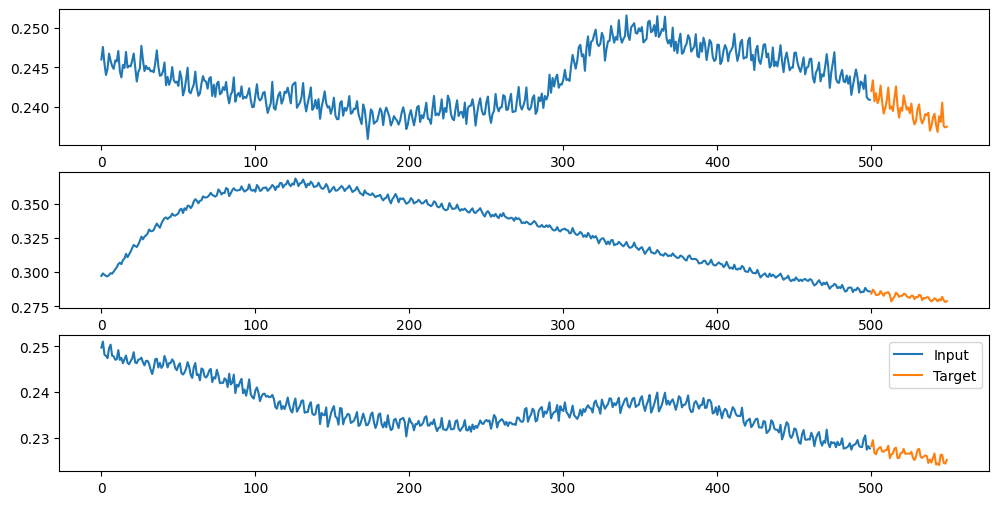

In [77]:
# Use only a subset of the data for faster training
num_samples = 10000
X_data = X[:num_samples]
y_data = y[:num_samples]

# Create dataloader
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

# Plot 3 samples around the reward/punish transition
plt.figure(figsize=(12, 6))
eventIdx = np.linspace(510,530,3).astype(int)
for i, event in enumerate(eventIdx):
    plt.subplot(3, 1, i+1)
    plt.plot(X_train[event], label='Input')
    plt.plot(np.arange(input_window, input_window + pred_window), y_train[event], label='Target')
plt.legend()
plt.show()

In [51]:
# Create dataset and DataLoader

# time_series = [torch.randn(input_window, 1) for _ in range(num_trials)]
# print(f"len(time_series): {len(time_series)}")
# print(f"time_series[0].shape: {time_series[0].shape}")

# dataloader = Dataloader_MultiTimeSeries(
#     timeseries=time_series, 
#     batch_size=32, 
#     input_duration=input_window, 
#     target_duration=pred_window,
#     shuffle_datasets=True, 
#     shuffle_startIdx=True
# )


In [81]:
# Model parameters
input_size = 1
hidden_size = 10  # Can be tuned
num_layers = 1

# # Initialize the model
# model = bnpm.neural_networks.RegressionRNN(
#     features=input_size, 
#     hidden_size=hidden_size, 
#     num_layers=num_layers, 
#     output_size=1,
#     batch_first=True,
#     architecture='GRU',
#     kwargs_architecture={},
#     nonlinearity='tanh',
#     bias=True,
#     dropout=0,
#     bidirectional=False,
#     device=device,
#     dtype=torch.float32,
# ).to(device)

model = ControllerRNN(
    input_size=input_size, 
    hidden_size=hidden_size, 
    output_size=1, 
    num_layers=num_layers, 
    pred_window=pred_window,
    nonlinearity='tanh',
    rnn_type='RNN',
).to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [82]:
num_epochs = 100
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    ##############################
    # Training Phase
    ##############################
    model.train()  # Set model to training mode
    train_epoch_loss = 0.0

    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move to GPU

        # Forward pass
        outputs = model(inputs)  # (batch_size, 200, 1)

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    avg_train_loss = train_epoch_loss / len(train_dataloader)
    train_loss_history.append(avg_train_loss)

    ##############################
    # Validation Phase
    ##############################
    model.eval()  # Set model to evaluation mode (no dropout, batchnorm fixed)
    val_epoch_loss = 0.0

    with torch.no_grad():  # No gradient computation for validation
        for inputs, targets in val_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)
            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_dataloader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

##############################
# Testing Phase (Final Evaluation)
##############################
model.eval()
test_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, targets)
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_dataloader)
print(f"Final Test Loss: {avg_test_loss:.4f}")

print("Training complete!")


Epoch [1/100], Train Loss: 0.0134, Val Loss: 0.0039
Epoch [2/100], Train Loss: 0.0037, Val Loss: 0.0039
Epoch [3/100], Train Loss: 0.0036, Val Loss: 0.0039
Epoch [4/100], Train Loss: 0.0035, Val Loss: 0.0039
Epoch [5/100], Train Loss: 0.0035, Val Loss: 0.0039
Epoch [6/100], Train Loss: 0.0035, Val Loss: 0.0039
Epoch [7/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [8/100], Train Loss: 0.0035, Val Loss: 0.0039
Epoch [9/100], Train Loss: 0.0035, Val Loss: 0.0039
Epoch [10/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [11/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [12/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [13/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [14/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [15/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [16/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [17/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [18/100], Train Loss: 0.0035, Val Loss: 0.0038
Epoch [19/100], Train Loss: 0.0035, Val Loss: 0.0038
Ep

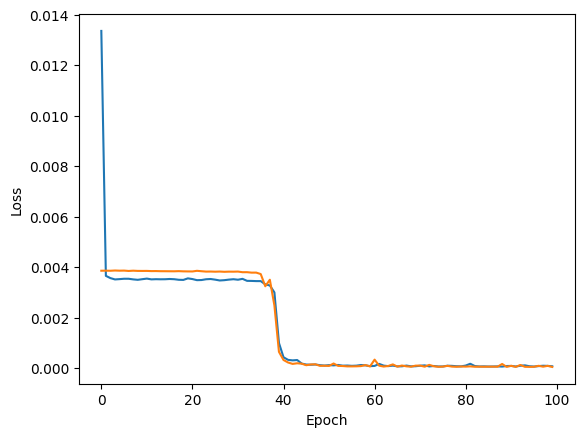

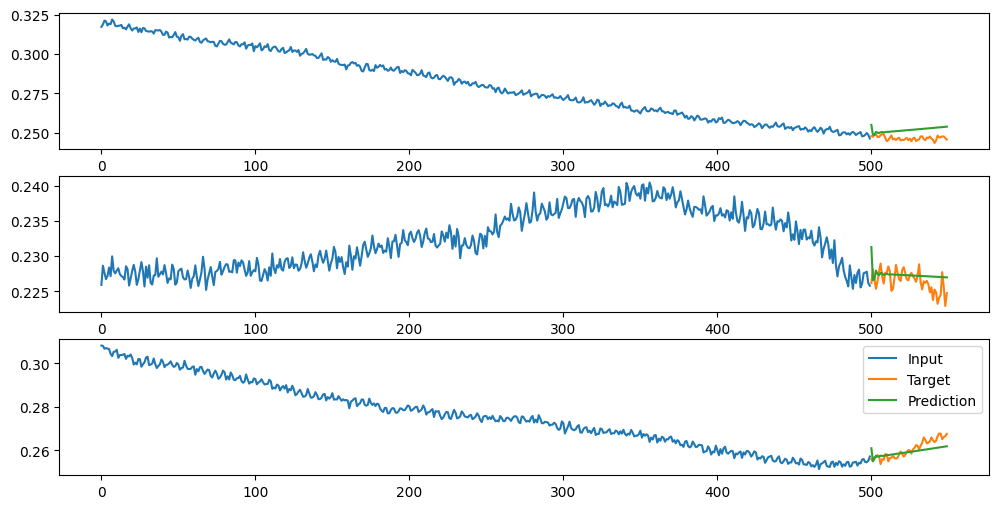

In [83]:
# Plot epoch loss
plt.figure()
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Plot predictions
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(test_dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.plot(inputs[i].cpu().numpy(), label='Input')
        plt.plot(np.arange(input_window, input_window + pred_window), targets[i].cpu().numpy(), label='Target')
        plt.plot(np.arange(input_window, input_window + pred_window), outputs[i].cpu().numpy(), label='Prediction')
    plt.legend()
    plt.show()
